<a href="https://colab.research.google.com/github/liuxin85/Image-Generation/blob/main/deep_fakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
    !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
    !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
    !unzip -q person_images.zip
    !pip install -q torch_snippets torch_summary
    from torch_snippets import *
    from random_warp import get_training_data

     |████████████████████████████████| 61kB 9.8MB/s 


2021-02-26 14:31:34.134 | WARNING  | torch_snippets.torch_loader:<module>:232 - Not importing Lightning Report


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if (len(faces) > 0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h), x:(x+w), :]
        img2 = cv2.resize(img2, (256, 256))
        return img2, True
    else:
        return img, False

In [ ]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

In [ ]:
def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i], 1)
        img2, face_detected = crop_face(img)
        if (face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg', 
                        cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

crop_images('personA')
crop_images('personB')


2021-02-26 14:31:34.437 | INFO     | torch_snippets.loader:Glob:221 - 444 files found at personA/*.jpg
2021-02-26 14:31:41.010 | INFO     | torch_snippets.loader:Glob:221 - 265 files found at personB/*.jpg


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f, 1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f, 1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0,1,2)) - self.items_A.mean(axis=(0,1,2))
    
    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b
    
    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device)\
                                        for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB
    
a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))

x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

2021-02-26 14:31:44.621 | INFO     | torch_snippets.loader:Glob:221 - 349 files found at cropped_faces_personA
2021-02-26 14:31:44.622 | INFO     | torch_snippets.loader:Glob:221 - 105 files found at cropped_faces_personB


2021-02-26 14:31:56.439 | INFO     | torch_snippets.loader:subplots:427 - plotting 8 images in a grid of 2x4 @ (5, 5)


Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.012	Max: 0.880	Mean: 0.503	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.062	Max: 0.931	Mean: 0.493	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.008	Max: 0.880	Mean: 0.504	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.062	Max: 0.930	Mean: 0.495	dtype: torch.float32


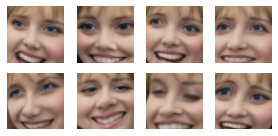

2021-02-26 14:31:56.689 | INFO     | torch_snippets.loader:subplots:427 - plotting 8 images in a grid of 2x4 @ (5, 5)


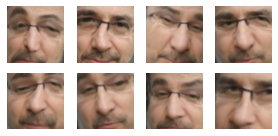

2021-02-26 14:31:56.941 | INFO     | torch_snippets.loader:subplots:427 - plotting 8 images in a grid of 2x4 @ (5, 5)


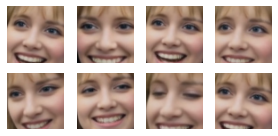

2021-02-26 14:31:57.253 | INFO     | torch_snippets.loader:subplots:427 - plotting 8 images in a grid of 2x4 @ (5, 5)


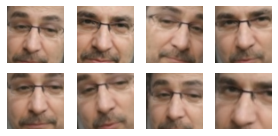

In [ ]:
inspect(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [ ]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features,
                  kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features,
                           kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4)
        return output

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024),
            nn.Linear(1024, 1024*4*4),
            Reshape(),
            _UpScale(1024, 512),
        )
        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),    
        )
    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [ ]:
from torchsummary import summary
model = Autoencoder()
summary(model, torch.zeros(32,3, 64, 64), 'A');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         9,728
|    |    └─LeakyReLU: 3-2               [-1, 128, 32, 32]         --
|    └─Sequential: 2-2                   [-1, 256, 16, 16]         --
|    |    └─Conv2d: 3-3                  [-1, 256, 16, 16]         819,456
|    |    └─LeakyReLU: 3-4               [-1, 256, 16, 16]         --
|    └─Sequential: 2-3                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-5                  [-1, 512, 8, 8]           3,277,312
|    |    └─LeakyReLU: 3-6               [-1, 512, 8, 8]           --
|    └─Sequential: 2-4                   [-1, 1024, 4, 4]          --
|    |    └─Conv2d: 3-7                  [-1, 1024, 4, 4]          13,108,224
|    |    └─LeakyReLU: 3-8               [-1, 1024, 4, 4]     

In [ ]:
def train_batch(model, data, criterion, optimizers):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')
    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [ ]:
model = Autoencoder().to(device)
dataset = ImageDataset(Glob('cropped_faces_personA'),
                       Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)
optimizers = optim.Adam(
    [{'params': model.encoder.parameters()},
     {'params': model.decoder_A.parameters()}],
     lr=5e-5, betas=(0.5, 0.999)),\
     optim.Adam(
    [{'params': model.encoder.parameters()},
     {'params': model.decoder_B.parameters()}],
     lr=5e-5, betas=(0.5, 0.999))

criterion = nn.L1Loss()

2021-02-26 14:31:58.483 | INFO     | torch_snippets.loader:Glob:221 - 349 files found at cropped_faces_personA
2021-02-26 14:31:58.485 | INFO     | torch_snippets.loader:Glob:221 - 105 files found at cropped_faces_personB


EPOCH: 1.000	lossA: 0.137	lossB: 0.145	(1.30s - 1297.99s remaining)
EPOCH: 2.000	lossA: 0.138	lossB: 0.142	(2.33s - 1163.04s remaining)
EPOCH: 3.000	lossA: 0.131	lossB: 0.136	(3.36s - 1115.48s remaining)
EPOCH: 4.000	lossA: 0.113	lossB: 0.123	(4.40s - 1095.35s remaining)
EPOCH: 5.000	lossA: 0.102	lossB: 0.110	(5.43s - 1080.93s remaining)
EPOCH: 6.000	lossA: 0.095	lossB: 0.105	(6.44s - 1067.49s remaining)
EPOCH: 7.000	lossA: 0.096	lossB: 0.103	(7.47s - 1060.04s remaining)
EPOCH: 8.000	lossA: 0.092	lossB: 0.101	(8.48s - 1051.17s remaining)
EPOCH: 9.000	lossA: 0.091	lossB: 0.103	(9.50s - 1045.93s remaining)
EPOCH: 10.000	lossA: 0.092	lossB: 0.101	(10.53s - 1042.03s remaining)
EPOCH: 11.000	lossA: 0.093	lossB: 0.101	(11.56s - 1039.31s remaining)
EPOCH: 12.000	lossA: 0.091	lossB: 0.101	(12.59s - 1036.48s remaining)
EPOCH: 13.000	lossA: 0.092	lossB: 0.100	(13.63s - 1034.80s remaining)
EPOCH: 14.000	lossA: 0.092	lossB: 0.100	(14.67s - 1033.07s remaining)
EPOCH: 15.000	lossA: 0.088	lossB: 0.09

2021-02-26 14:33:44.888 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


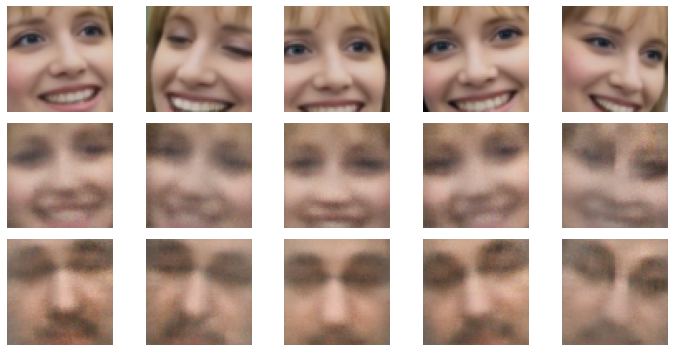

2021-02-26 14:33:45.468 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


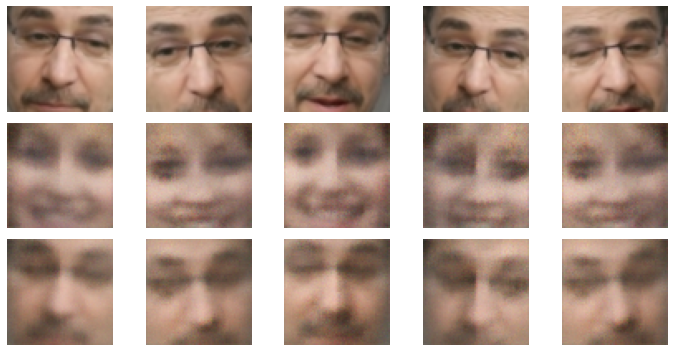

EPOCH: 101.000	lossA: 0.062	lossB: 0.051	(107.31s - 955.12s remaining)
EPOCH: 102.000	lossA: 0.062	lossB: 0.053	(108.33s - 953.77s remaining)
EPOCH: 103.000	lossA: 0.060	lossB: 0.054	(109.39s - 952.69s remaining)
EPOCH: 104.000	lossA: 0.061	lossB: 0.052	(110.44s - 951.52s remaining)
EPOCH: 105.000	lossA: 0.064	lossB: 0.051	(111.47s - 950.16s remaining)
EPOCH: 106.000	lossA: 0.063	lossB: 0.051	(112.51s - 948.92s remaining)
EPOCH: 107.000	lossA: 0.061	lossB: 0.049	(113.56s - 947.73s remaining)
EPOCH: 108.000	lossA: 0.060	lossB: 0.048	(114.60s - 946.54s remaining)
EPOCH: 109.000	lossA: 0.059	lossB: 0.050	(115.62s - 945.11s remaining)
EPOCH: 110.000	lossA: 0.061	lossB: 0.048	(116.65s - 943.82s remaining)
EPOCH: 111.000	lossA: 0.059	lossB: 0.049	(117.68s - 942.47s remaining)
EPOCH: 112.000	lossA: 0.058	lossB: 0.050	(118.71s - 941.17s remaining)
EPOCH: 113.000	lossA: 0.059	lossB: 0.049	(119.77s - 940.12s remaining)
EPOCH: 114.000	lossA: 0.058	lossB: 0.048	(120.80s - 938.86s remaining)
EPOCH:

2021-02-26 14:35:31.332 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


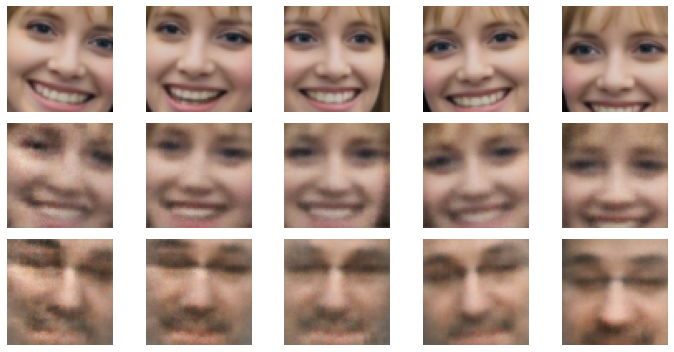

2021-02-26 14:35:31.925 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


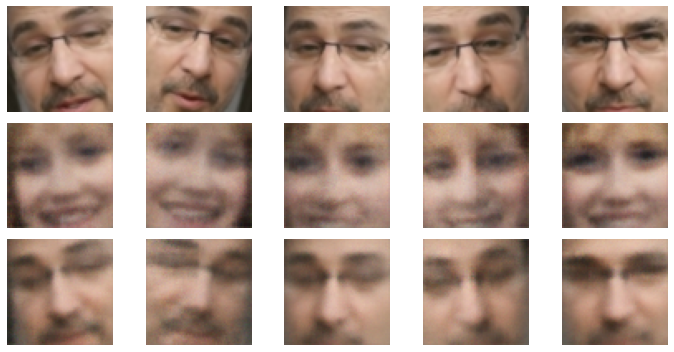

EPOCH: 201.000	lossA: 0.047	lossB: 0.041	(213.79s - 849.85s remaining)
EPOCH: 202.000	lossA: 0.047	lossB: 0.040	(214.85s - 848.76s remaining)
EPOCH: 203.000	lossA: 0.047	lossB: 0.039	(215.89s - 847.62s remaining)
EPOCH: 204.000	lossA: 0.047	lossB: 0.040	(216.94s - 846.49s remaining)
EPOCH: 205.000	lossA: 0.048	lossB: 0.040	(217.98s - 845.35s remaining)
EPOCH: 206.000	lossA: 0.047	lossB: 0.040	(219.04s - 844.27s remaining)
EPOCH: 207.000	lossA: 0.046	lossB: 0.039	(220.09s - 843.13s remaining)
EPOCH: 208.000	lossA: 0.046	lossB: 0.039	(221.14s - 842.04s remaining)
EPOCH: 209.000	lossA: 0.046	lossB: 0.040	(222.19s - 840.91s remaining)
EPOCH: 210.000	lossA: 0.046	lossB: 0.041	(223.23s - 839.78s remaining)
EPOCH: 211.000	lossA: 0.045	lossB: 0.039	(224.28s - 838.66s remaining)
EPOCH: 212.000	lossA: 0.045	lossB: 0.038	(225.32s - 837.50s remaining)
EPOCH: 213.000	lossA: 0.046	lossB: 0.039	(226.37s - 836.41s remaining)
EPOCH: 214.000	lossA: 0.046	lossB: 0.039	(227.44s - 835.37s remaining)
EPOCH:

2021-02-26 14:37:18.256 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


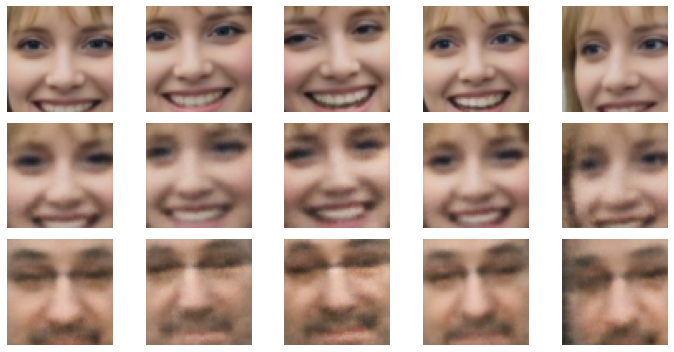

2021-02-26 14:37:18.846 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


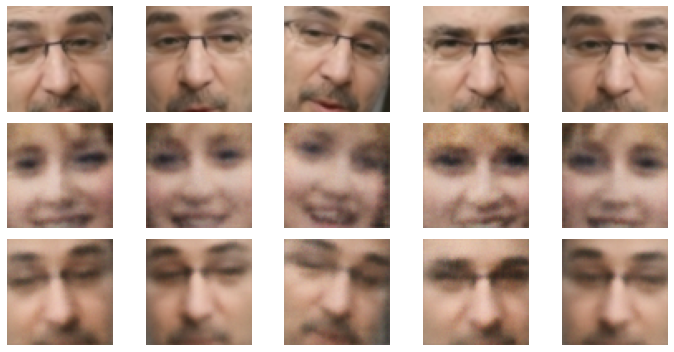

EPOCH: 301.000	lossA: 0.039	lossB: 0.035	(320.72s - 744.81s remaining)
EPOCH: 302.000	lossA: 0.041	lossB: 0.034	(321.77s - 743.70s remaining)
EPOCH: 303.000	lossA: 0.038	lossB: 0.035	(322.82s - 742.60s remaining)
EPOCH: 304.000	lossA: 0.040	lossB: 0.034	(323.88s - 741.52s remaining)
EPOCH: 305.000	lossA: 0.039	lossB: 0.034	(324.94s - 740.43s remaining)
EPOCH: 306.000	lossA: 0.042	lossB: 0.033	(325.99s - 739.33s remaining)
EPOCH: 307.000	lossA: 0.039	lossB: 0.035	(327.05s - 738.26s remaining)
EPOCH: 308.000	lossA: 0.040	lossB: 0.035	(328.10s - 737.16s remaining)
EPOCH: 309.000	lossA: 0.039	lossB: 0.035	(329.17s - 736.10s remaining)
EPOCH: 310.000	lossA: 0.039	lossB: 0.035	(330.22s - 735.00s remaining)
EPOCH: 311.000	lossA: 0.039	lossB: 0.034	(331.25s - 733.86s remaining)
EPOCH: 312.000	lossA: 0.041	lossB: 0.034	(332.30s - 732.76s remaining)
EPOCH: 313.000	lossA: 0.041	lossB: 0.034	(333.36s - 731.68s remaining)
EPOCH: 314.000	lossA: 0.041	lossB: 0.034	(334.41s - 730.59s remaining)
EPOCH:

2021-02-26 14:39:05.738 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==============================A TO B==============================


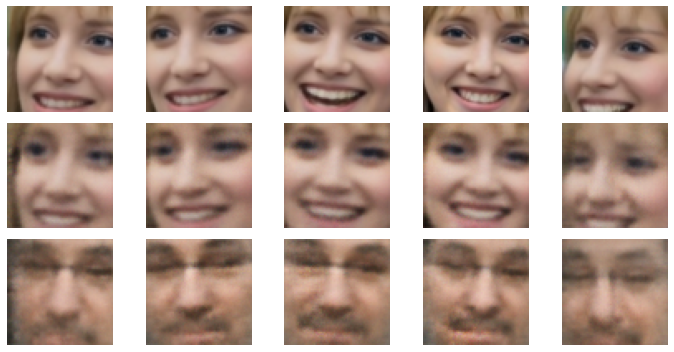

2021-02-26 14:39:06.362 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


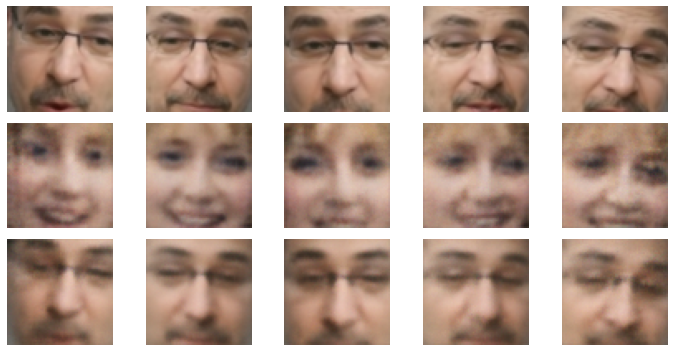

EPOCH: 401.000	lossA: 0.036	lossB: 0.031	(428.26s - 639.73s remaining)
EPOCH: 402.000	lossA: 0.036	lossB: 0.032	(429.31s - 638.62s remaining)
EPOCH: 403.000	lossA: 0.037	lossB: 0.032	(430.36s - 637.53s remaining)
EPOCH: 404.000	lossA: 0.038	lossB: 0.032	(431.41s - 636.44s remaining)
EPOCH: 405.000	lossA: 0.037	lossB: 0.032	(432.47s - 635.35s remaining)
EPOCH: 406.000	lossA: 0.038	lossB: 0.032	(433.52s - 634.27s remaining)
EPOCH: 407.000	lossA: 0.035	lossB: 0.032	(434.59s - 633.20s remaining)
EPOCH: 408.000	lossA: 0.037	lossB: 0.031	(435.64s - 632.11s remaining)
EPOCH: 409.000	lossA: 0.037	lossB: 0.031	(436.70s - 631.03s remaining)
EPOCH: 410.000	lossA: 0.036	lossB: 0.031	(437.75s - 629.94s remaining)
EPOCH: 411.000	lossA: 0.036	lossB: 0.031	(438.81s - 628.85s remaining)
EPOCH: 412.000	lossA: 0.037	lossB: 0.032	(439.85s - 627.75s remaining)
EPOCH: 413.000	lossA: 0.037	lossB: 0.032	(440.92s - 626.68s remaining)
EPOCH: 414.000	lossA: 0.035	lossB: 0.031	(441.99s - 625.62s remaining)
EPOCH:

2021-02-26 14:40:53.176 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


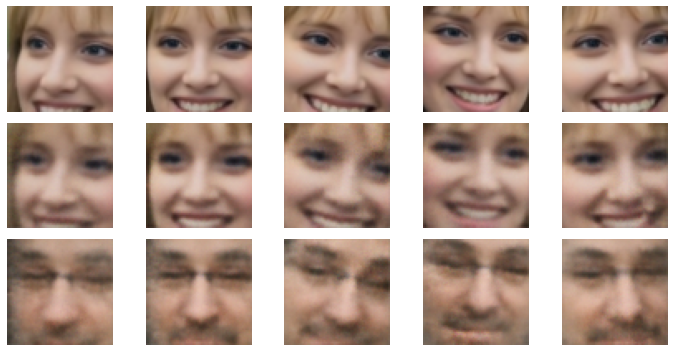

2021-02-26 14:40:53.784 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


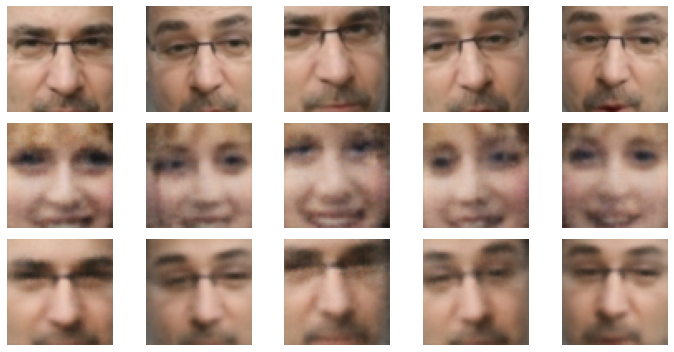

EPOCH: 501.000	lossA: 0.033	lossB: 0.029	(535.62s - 533.49s remaining)
EPOCH: 502.000	lossA: 0.035	lossB: 0.030	(536.69s - 532.41s remaining)
EPOCH: 503.000	lossA: 0.034	lossB: 0.029	(537.76s - 531.35s remaining)
EPOCH: 504.000	lossA: 0.035	lossB: 0.029	(538.81s - 530.25s remaining)
EPOCH: 505.000	lossA: 0.034	lossB: 0.029	(539.86s - 529.17s remaining)
EPOCH: 506.000	lossA: 0.034	lossB: 0.030	(540.91s - 528.09s remaining)
EPOCH: 507.000	lossA: 0.033	lossB: 0.030	(541.97s - 527.00s remaining)
EPOCH: 508.000	lossA: 0.033	lossB: 0.029	(543.05s - 525.94s remaining)
EPOCH: 509.000	lossA: 0.033	lossB: 0.029	(544.11s - 524.86s remaining)
EPOCH: 510.000	lossA: 0.034	lossB: 0.029	(545.18s - 523.80s remaining)
EPOCH: 511.000	lossA: 0.033	lossB: 0.030	(546.24s - 522.72s remaining)
EPOCH: 512.000	lossA: 0.034	lossB: 0.030	(547.30s - 521.64s remaining)
EPOCH: 513.000	lossA: 0.033	lossB: 0.030	(548.36s - 520.57s remaining)
EPOCH: 514.000	lossA: 0.034	lossB: 0.030	(549.45s - 519.51s remaining)
EPOCH:

2021-02-26 14:42:41.193 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


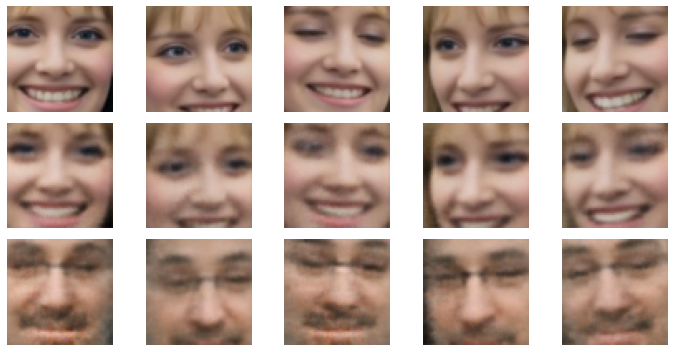

2021-02-26 14:42:41.813 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


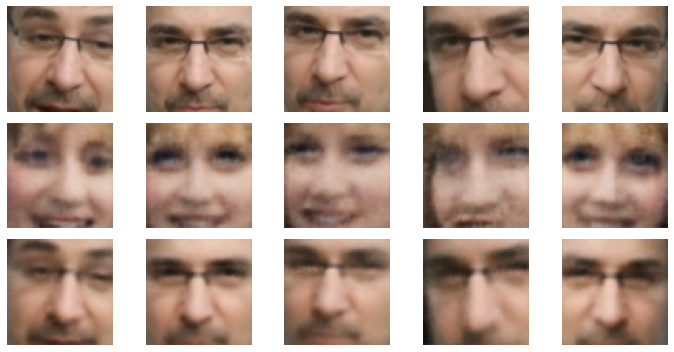

EPOCH: 601.000	lossA: 0.033	lossB: 0.029	(643.67s - 427.33s remaining)
EPOCH: 602.000	lossA: 0.034	lossB: 0.027	(644.74s - 426.26s remaining)
EPOCH: 603.000	lossA: 0.033	lossB: 0.028	(645.79s - 425.17s remaining)
EPOCH: 604.000	lossA: 0.032	lossB: 0.028	(646.85s - 424.09s remaining)
EPOCH: 605.000	lossA: 0.032	lossB: 0.027	(647.89s - 423.01s remaining)
EPOCH: 606.000	lossA: 0.032	lossB: 0.029	(648.94s - 421.92s remaining)
EPOCH: 607.000	lossA: 0.032	lossB: 0.028	(649.99s - 420.83s remaining)
EPOCH: 608.000	lossA: 0.031	lossB: 0.027	(651.04s - 419.75s remaining)
EPOCH: 609.000	lossA: 0.033	lossB: 0.027	(652.10s - 418.67s remaining)
EPOCH: 610.000	lossA: 0.032	lossB: 0.027	(653.15s - 417.59s remaining)
EPOCH: 611.000	lossA: 0.032	lossB: 0.029	(654.22s - 416.52s remaining)
EPOCH: 612.000	lossA: 0.031	lossB: 0.027	(655.27s - 415.43s remaining)
EPOCH: 613.000	lossA: 0.033	lossB: 0.026	(656.34s - 414.36s remaining)
EPOCH: 614.000	lossA: 0.031	lossB: 0.028	(657.39s - 413.28s remaining)
EPOCH:

2021-02-26 14:44:29.207 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


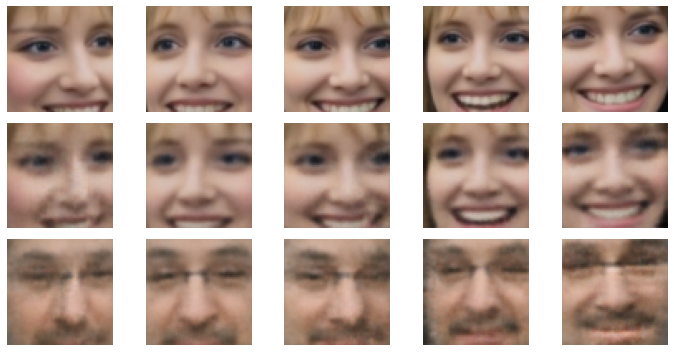

2021-02-26 14:44:29.883 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


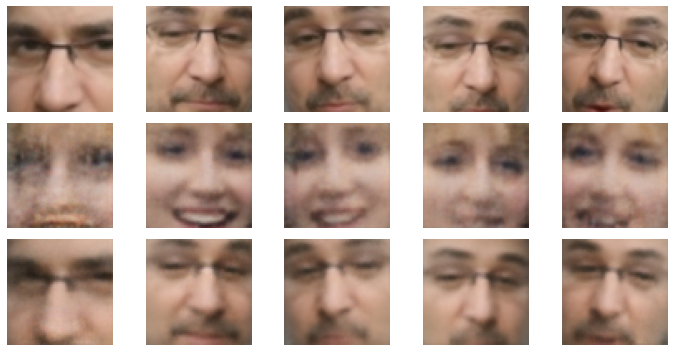

EPOCH: 701.000	lossA: 0.032	lossB: 0.028	(751.74s - 320.64s remaining)
EPOCH: 702.000	lossA: 0.029	lossB: 0.026	(752.81s - 319.57s remaining)
EPOCH: 703.000	lossA: 0.032	lossB: 0.027	(753.87s - 318.49s remaining)
EPOCH: 704.000	lossA: 0.031	lossB: 0.026	(754.92s - 317.41s remaining)
EPOCH: 705.000	lossA: 0.031	lossB: 0.026	(755.99s - 316.33s remaining)
EPOCH: 706.000	lossA: 0.030	lossB: 0.027	(757.03s - 315.25s remaining)
EPOCH: 707.000	lossA: 0.030	lossB: 0.026	(758.10s - 314.18s remaining)
EPOCH: 708.000	lossA: 0.032	lossB: 0.027	(759.15s - 313.10s remaining)
EPOCH: 709.000	lossA: 0.030	lossB: 0.026	(760.22s - 312.02s remaining)
EPOCH: 710.000	lossA: 0.031	lossB: 0.027	(761.28s - 310.94s remaining)
EPOCH: 711.000	lossA: 0.031	lossB: 0.027	(762.31s - 309.86s remaining)
EPOCH: 712.000	lossA: 0.031	lossB: 0.026	(763.37s - 308.78s remaining)
EPOCH: 713.000	lossA: 0.031	lossB: 0.028	(764.44s - 307.71s remaining)
EPOCH: 714.000	lossA: 0.031	lossB: 0.026	(765.50s - 306.63s remaining)
EPOCH:

2021-02-26 14:46:17.550 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


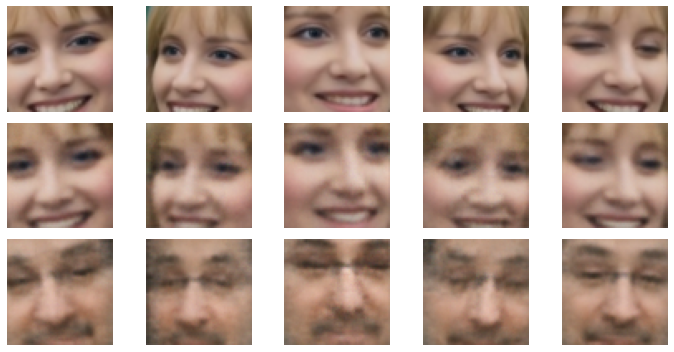

2021-02-26 14:46:18.263 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


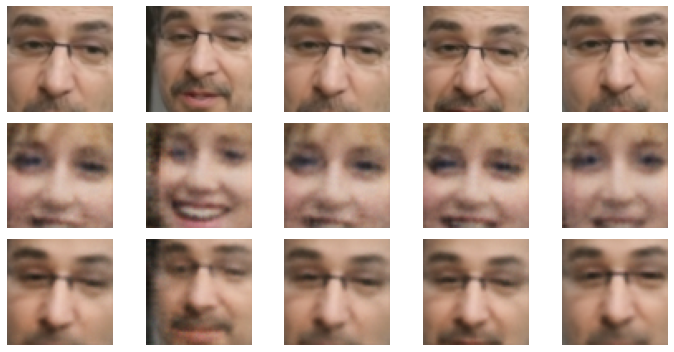

EPOCH: 801.000	lossA: 0.029	lossB: 0.026	(860.16s - 213.70s remaining)
EPOCH: 802.000	lossA: 0.030	lossB: 0.026	(861.23s - 212.62s remaining)
EPOCH: 803.000	lossA: 0.030	lossB: 0.026	(862.28s - 211.54s remaining)
EPOCH: 804.000	lossA: 0.029	lossB: 0.026	(863.34s - 210.47s remaining)
EPOCH: 805.000	lossA: 0.030	lossB: 0.026	(864.39s - 209.39s remaining)
EPOCH: 806.000	lossA: 0.029	lossB: 0.024	(865.44s - 208.31s remaining)
EPOCH: 807.000	lossA: 0.030	lossB: 0.026	(866.49s - 207.23s remaining)
EPOCH: 808.000	lossA: 0.028	lossB: 0.024	(867.56s - 206.15s remaining)
EPOCH: 809.000	lossA: 0.028	lossB: 0.026	(868.63s - 205.08s remaining)
EPOCH: 810.000	lossA: 0.028	lossB: 0.025	(869.69s - 204.00s remaining)
EPOCH: 811.000	lossA: 0.030	lossB: 0.025	(870.73s - 202.92s remaining)
EPOCH: 812.000	lossA: 0.030	lossB: 0.026	(871.80s - 201.84s remaining)
EPOCH: 813.000	lossA: 0.029	lossB: 0.025	(872.87s - 200.77s remaining)
EPOCH: 814.000	lossA: 0.029	lossB: 0.025	(873.96s - 199.70s remaining)
EPOCH:

2021-02-26 14:48:05.957 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


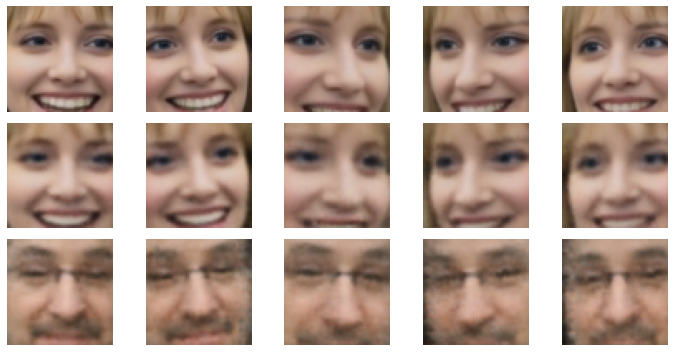

2021-02-26 14:48:06.637 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


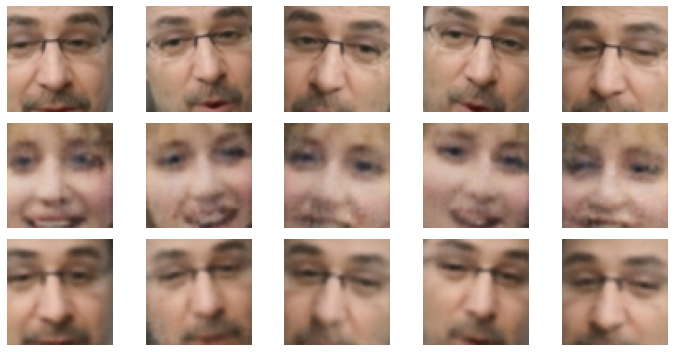

EPOCH: 901.000	lossA: 0.028	lossB: 0.025	(968.54s - 106.42s remaining)
EPOCH: 902.000	lossA: 0.028	lossB: 0.024	(969.63s - 105.35s remaining)
EPOCH: 903.000	lossA: 0.029	lossB: 0.026	(970.70s - 104.27s remaining)
EPOCH: 904.000	lossA: 0.029	lossB: 0.024	(971.77s - 103.20s remaining)
EPOCH: 905.000	lossA: 0.029	lossB: 0.025	(972.85s - 102.12s remaining)
EPOCH: 906.000	lossA: 0.029	lossB: 0.024	(973.91s - 101.05s remaining)
EPOCH: 907.000	lossA: 0.027	lossB: 0.024	(974.98s - 99.97s remaining)
EPOCH: 908.000	lossA: 0.029	lossB: 0.025	(976.05s - 98.89s remaining)
EPOCH: 909.000	lossA: 0.031	lossB: 0.025	(977.13s - 97.82s remaining)
EPOCH: 910.000	lossA: 0.029	lossB: 0.025	(978.19s - 96.74s remaining)
EPOCH: 911.000	lossA: 0.029	lossB: 0.025	(979.29s - 95.67s remaining)
EPOCH: 912.000	lossA: 0.028	lossB: 0.024	(980.34s - 94.59s remaining)
EPOCH: 913.000	lossA: 0.027	lossB: 0.024	(981.44s - 93.52s remaining)
EPOCH: 914.000	lossA: 0.029	lossB: 0.024	(982.51s - 92.45s remaining)
EPOCH: 915.000

2021-02-26 14:49:54.706 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


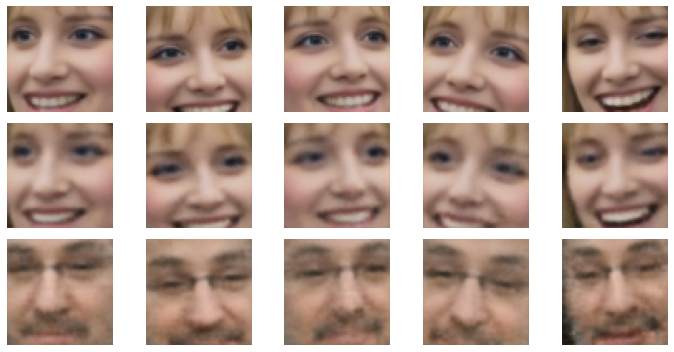

2021-02-26 14:49:55.388 | INFO     | torch_snippets.loader:subplots:427 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


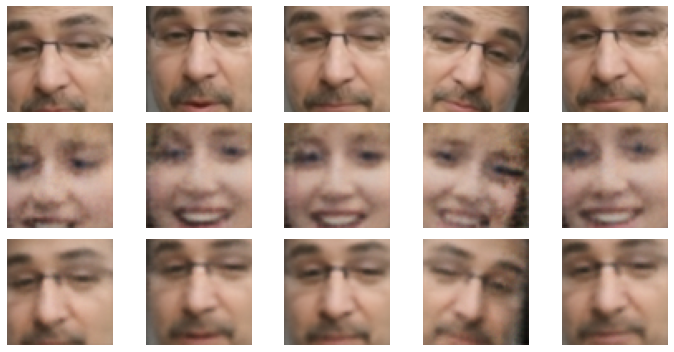

100%|██████████| 1101/1101 [00:01<00:00, 641.13it/s]


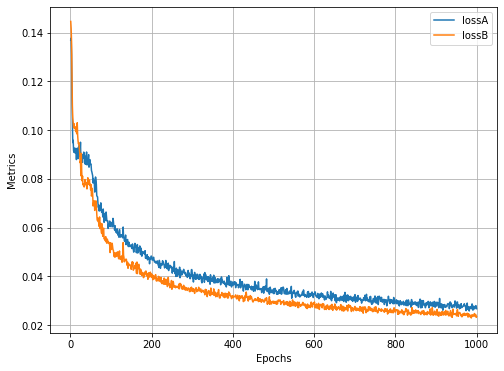

In [ ]:
# Train the model
n_epochs = 1000
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx, data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')
    log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
            'state': model.state_dict(),
            'epoch': ex
        }
        torch.save(state, './checkpoint/autoencoder.pth')
    if (ex+1)%100 == 0:
        bs = 5
        a,b, A, B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a, _b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()